# import

In [3]:
# run import

In [2]:
from control import matlab
from matplotlib import pyplot as plt
import numpy as np
from scipy import linalg as LA

# Control class

In [6]:
# run class

In [4]:
class systemd:
    def __init__(self, A, B, E, C, Ts):
        br, bc = B.shape
        cr, cc = C.shape
        sys1 = matlab.ss(A, B, C, np.zeros((cr, bc)))
        sys1d = matlab.c2d(sys1, Ts)
        br, bc = E.shape
        cr, cc = C.shape
        sys2 = matlab.ss(A, E, C, np.zeros((cr, bc)))
        sys2d = matlab.c2d(sys2, Ts)
        self.A = sys1d.A
        self.B = sys1d.B
        self.E = sys2d.B
        self.C = sys1d.C
        
    def update(self, x1, u1, d1):
        x2 = self.A.dot(x1) + self.B.dot(u1) + self.E.dot(d1)
        y2 = self.C.dot(x1)
        return x2, y2

In [5]:
class mycontrol:
    """
    離散システム用
    y(k+1) = Ad*x(t) + Bd*u(k) + Ed*d(k) 想定
    """
            
    def ss(A, B, E, C, Ts):
        return systemd(A, B, E, C, Ts)
    
    def lqrd(A, B, Q, R):
        """
        離散系最適レギュレータ
        """
        P = LA.solve_discrete_are(A, B, Q, R)
        K = LA.inv(R+B.T.dot(P).dot(B)).dot(B.T).dot(P).dot(A)
        E = None
        
        return P, K, E

# Common Param

In [10]:
# run common param

## 入力値

In [8]:
m = 534 # 車体重量 kg
Is = 785 # 車体の慣性モーメント kg*m^2
kf = 13569 # 前輪支持ばね定数 N/m
kr = 17681 # 後輪支持ばね定数 N/m
cf = 1200 # 前輪支持減衰定数 Ns/m
cr = 1299 # 後輪支持減衰定数 Ns/m
a = 1.2 # 車体重心と前輪軸間距離 mb
b = 1.3 # 車体重心と後輪軸間距離 m

Ts = 0.001 # サンプリング周期 sec
# vhm = 50 # 車両速度 km/h
hd = 0.08 # 外乱高さ m
ld = 3 # 外乱長さ m
dl = 5 # 外乱までの距離 m

# q = np.array([1, 100, 1, 1, 1, 1]) # 重み行列Q用 1x6
h = np.array([1, 1])*10**-5 # 重み行列H用 1x2
h = np.array([1, 1])*10**-5 # 重み行列H用 1x2

Cp = np.array(
    [
        [1, 0, 0, 0],
        [0, 0, 1, 0]
    ]
)

## 計算値

In [9]:
l = a+b  # ホイールベース間距離 m
# v = vhm*1000/3600  # 車両速度 m/s
# Q = np.diag(q)  # 重み行列Q 6x6
H = np.diag(h)  # 重み行列H 2x2

Ap = np.array(
    [
        [0, 1, 0, 0],
        np.array([-(kf+kr), -(cf+cr), kf*a-kr*b, cf*a-cr*b])/m,
        [0, 0, 0, 1],
        np.array([kf*a-kr*b, cf*a-cr*b, -(kf*a*a+kr*b*b), -(cf*a*a+cr*b*b)])/Is
    ]
)
Bp = np.array(
    [
        [0, 0],
        [1/m, 1/m],
        [0, 0],
        [-a/Is, b/Is]
    ]
)
Ep = np.array(
    [
        [0, 0, 0, 0],
        np.array([kf, cf, kr, cr])/m,
        [0, 0, 0, 0],
        np.array([-kf*a, -cf*a, kr*b, cr*b])/Is
    ]
)

# 外乱

In [12]:
# run disturbance

In [11]:
def w_dist(x):
    if x<= l:
        return 0
    elif x<= l+ld:
        return hd*(1-np.cos(2*np.pi*(x-l)/ld))/2
    else:
        return 0
    
def w_distd(x):
    xd = x%(l+ld+5)
    if xd<= l:
        return 0
    elif xd<= l+ld:
        return hd*(1-np.cos(2*np.pi*(xd-l)/ld))/2
    else:
        return 0
    
def dist(x, l):
    return w_dist(x+l), w_dist(x)

# sim1 速度一定

In [125]:
# run sim1

## 追加Common Param

In [120]:
sysd = mycontrol.ss(Ap, Bp, Ep, Cp, Ts)

start_time = 0
end_time = 2
t = np.arange(start_time, end_time, Ts)

vset = 50
vs = 50*1000/3600

## sim1_1 Passive model

In [90]:
# run passive model

In [121]:
x = np.zeros((t.size, 4, 1))
y = np.zeros((t.size, 2, 1))
u = np.zeros((t.size, 2, 1))
d = np.zeros((t.size, 4, 1))
dis = np.zeros((t.size))
v = vs
ddis = v*Ts

for i in range(t.size-1):
    x[i+1], y[i+1] = sysd.update(x[i], u[i], d[i])
    dis[i+1] = dis[i] + ddis
    d[i+1][0], d[i+1][2] = dist(dis[i+1], l)
    d[i+1][1][0] = (d[i+1][0]-d[i][0])/Ts
    d[i+1][3][0] = (d[i+1][2]-d[i][2])/Ts    
    
x11, y11, u11, d11, dis11 = x, y, u, d, dis

## sim1_2 Feedback model

In [92]:
# run feedback model

In [122]:
q = np.array([1, 100, 1, 1])
Q = np.diag(q)

P, K, E = mycontrol.lqrd(sysd.A, sysd.B, Q, H)
K = -K

x = np.zeros((t.size, 4, 1))
y = np.zeros((t.size, 2, 1))
u = np.zeros((t.size, 2, 1))
d = np.zeros((t.size, 4, 1))
dis = np.zeros((t.size))
v = vs
ddis = v*Ts

for i in range(t.size-1):
    x[i+1], y[i+1] = sysd.update(x[i], u[i], d[i])
    dis[i+1] = dis[i] + ddis
    d[i+1][0], d[i+1][2] = dist(dis[i+1], l)
    d[i+1][1][0] = (d[i+1][0]-d[i][0])/Ts
    d[i+1][3][0] = (d[i+1][2]-d[i][2])/Ts    
    
    u[i+1] = K.dot(x[i+1])
    
x12, y12, u12, d12, dis12 = x, y, u, d, dis

## sim1_3 Error System model

In [102]:
# run error system model

In [123]:
q = np.array([1, 100, 1, 1, 1, 1])
Q = np.diag(q)

phi = np.vstack(
    [
        np.hstack([np.eye(2), -sysd.C.dot(sysd.A)]),
        np.hstack([np.zeros([4, 2]), sysd.A])
    ]
)
G = np.vstack(
    [
        -sysd.C.dot(sysd.B),
        sysd.B
    ]
)
Gd = np.vstack(
    [
        -sysd.C.dot(sysd.E),
        sysd.E
    ]
)
syser = mycontrol.ss(phi, G, Gd, np.eye(6), Ts)

P, K, E = mycontrol.lqrd(phi, G, Q, H)
K = -K
Fe, Fx = np.hsplit(K, [2])

x = np.zeros((t.size, 4, 1))
y = np.zeros((t.size, 2, 1))
u = np.zeros((t.size, 2, 1))
d = np.zeros((t.size, 4, 1))
dis = np.zeros((t.size))
v = vs
ddis = v*Ts
e = np.zeros((t.size, 2, 1))

for i in range(t.size-1):
    x[i+1], y[i+1] = sysd.update(x[i], u[i], d[i])
    dis[i+1] = dis[i] + ddis
    d[i+1][0], d[i+1][2] = dist(dis[i+1], l)
    d[i+1][1][0] = (d[i+1][0]-d[i][0])/Ts
    d[i+1][3][0] = (d[i+1][2]-d[i][2])/Ts  
    
    e[i+1] = -y[i+1]
    dx = x[i+1] - x[i]
    du = Fe.dot(e[i+1]) + Fx.dot(dx)
    u[i+1] = u[i] + du
    
    
x13, y13, u13, d13, dis13 = x, y, u, d, dis

## sim1_4 Preview System model

In [108]:
# run preview system model

In [124]:
q = np.array([1, 100, 1, 1, 1, 1])
Q = np.diag(q)

phi = np.vstack(
    [
        np.hstack([np.eye(2), -sysd.C.dot(sysd.A)]),
        np.hstack([np.zeros([4, 2]), sysd.A])
    ]
)
G = np.vstack(
    [
        -sysd.C.dot(sysd.B),
        sysd.B
    ]
)
Gd = np.vstack(
    [
        -sysd.C.dot(sysd.E),
        sysd.E
    ]
)
syser = mycontrol.ss(phi, G, Gd, np.eye(6), Ts)

P, K, E = mycontrol.lqrd(phi, G, Q, H)
K = -K
Fe, Fx = np.hsplit(K, [2])

step = 43 # 予見ステップ数
Fd = np.zeros((step, 2, 4))
for i in range(step):
    Fd[i] = -LA.inv(H+G.T.dot(P).dot(G)).dot(G.T).dot(np.linalg.matrix_power((phi+G.dot(K)).T, i+1)).dot(P).dot(Gd)

x = np.zeros((t.size, 4, 1))
y = np.zeros((t.size, 2, 1))
u = np.zeros((t.size, 2, 1))
d = np.zeros((t.size, 4, 1))
dis = np.zeros((t.size))
v = vs
ddis = v*Ts
e = np.zeros((t.size, 2, 1))
yoken = np.zeros((t.size+100, 4, 1))
Mmax = int(l/(v*Ts))

for i in range(t.size-1):
    x[i+1], y[i+1] = sysd.update(x[i], u[i], d[i])
    dis[i+1] = dis[i] + ddis
    d[i+1][0], d[i+1][2] = dist(dis[i+1], l)
    d[i+1][1][0] = (d[i+1][0]-d[i][0])/Ts
    d[i+1][3][0] = (d[i+1][2]-d[i][2])/Ts  
    
    # 予見情報
    if i<t.size-Mmax-1:
        yoken[i+1+Mmax][2] = d[i+1][0]
        yoken[i+1+Mmax][3] = d[i+1][1]
    
    e[i+1] = -y[i+1]
    dx = x[i+1] - x[i]
    du = Fe.dot(e[i+1]) + Fx.dot(dx)
    
    for j in range(step):
        k = i + j+1
        dw = yoken[k+1]-yoken[k]
        du += Fd[j].dot(dw)
    
    u[i+1] = u[i] + du
    
    
x14, y14, u14, d14, dis14 = x, y, u, d, dis
yoken14 = yoken

## plot

In [130]:
# run sim1 plot

### 状態変数x

In [78]:
# run plot x

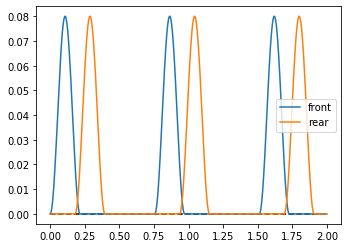

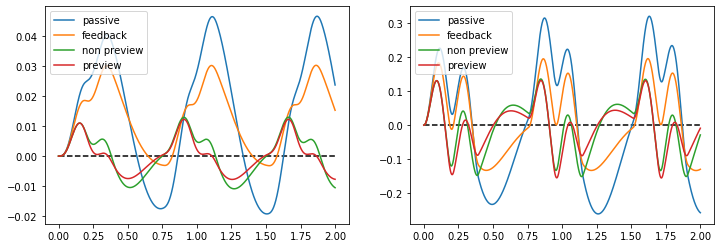

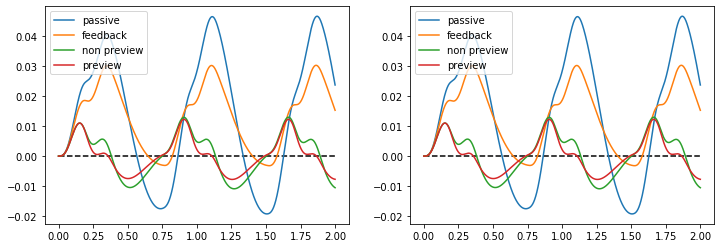

In [126]:
yn = (x11, x12, x13, x14, )
gn = ("passive", "feedback", "non preview", "preview")
d = d11

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(t, d11[:, 0], label='front')
plt.plot(t, d11[:, 2], label='rear')
plt.legend()
plt.hlines([0], 0, end_time, linestyles='dashed')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for i in range(len(yn)):
    plt.plot(t, yn[i][:, 0], label=gn[i])
plt.legend()
plt.hlines([0], 0, end_time, linestyles='dashed')

plt.subplot(1, 2, 2)
for i in range(len(yn)):
    plt.plot(t, yn[i][:, 1], label=gn[i])
plt.legend()
plt.hlines([0], 0, end_time, linestyles='dashed')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for i in range(len(yn)):
    plt.plot(t, yn[i][:, 0], label=gn[i])
plt.legend()
plt.hlines([0], 0, end_time, linestyles='dashed')

plt.subplot(1, 2, 2)
for i in range(len(yn)):
    plt.plot(t, yn[i][:, 0], label=gn[i])
plt.legend()
plt.hlines([0], 0, end_time, linestyles='dashed')

### 入力u

In [114]:
# run plot u

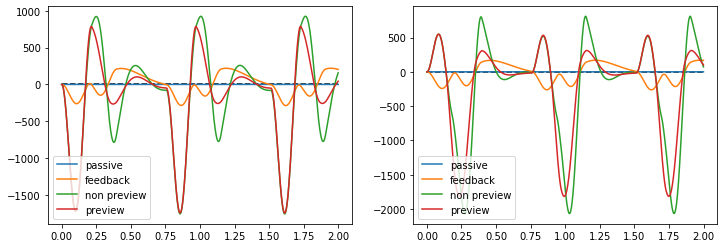

In [127]:
yn = (u11, u12, u13, u14, )
gn = ("passive","feedback", "non preview", "preview")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for i in range(len(yn)):
    plt.plot(t, yn[i][:, 0], label=gn[i])
plt.legend()
plt.hlines([0], 0, end_time, linestyles='dashed')

plt.subplot(1, 2, 2)
for i in range(len(yn)):
    plt.plot(t, yn[i][:, 1], label=gn[i])
plt.legend()
plt.hlines([0], 0, end_time, linestyles='dashed')

### 外乱d

In [116]:
# run plot d

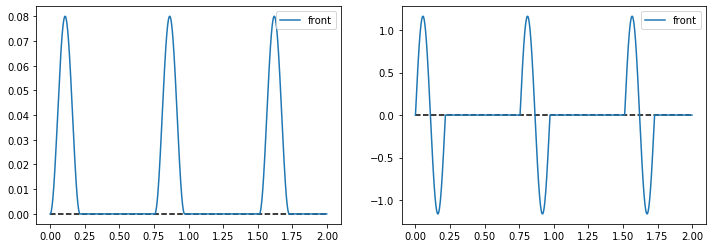

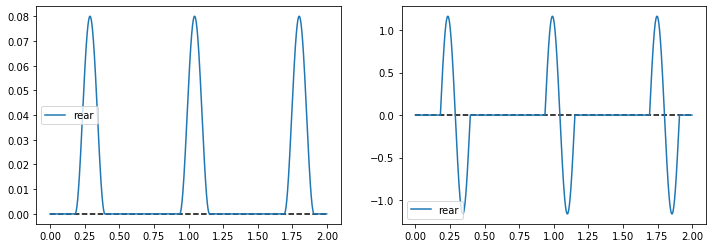

In [128]:
yn = (d11, )

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for y in yn:
    plt.plot(t, y[:, 0], label='front')
plt.hlines([0], 0, end_time, linestyles='dashed')
plt.legend()

plt.subplot(1, 2, 2)
for y in yn:
    plt.plot(t, y[:, 1], label='front')
plt.hlines([0], 0, end_time, linestyles='dashed')
plt.legend()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for y in yn:
    plt.plot(t, y[:, 2], label='rear')
plt.hlines([0], 0, end_time, linestyles='dashed')
plt.legend()

plt.subplot(1, 2, 2)
for y in yn:
    plt.plot(t, y[:, 3], label='rear')
plt.hlines([0], 0, end_time, linestyles='dashed')
plt.legend()

### 距離dis

In [118]:
# run plot dis

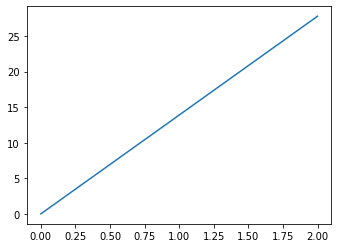

In [129]:
yn = (dis11, )

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for y in yn:
    plt.plot(t, y)

### 予見情報yoken

In [177]:
# run plot yoken

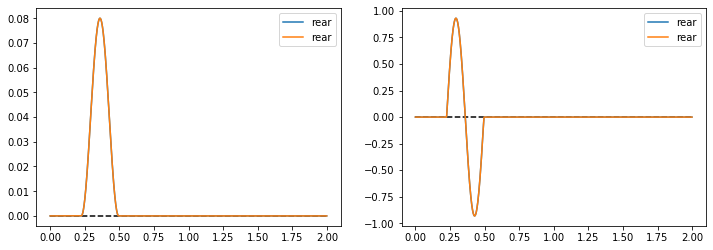

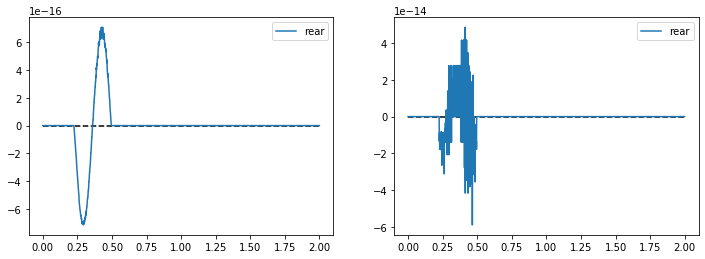

In [187]:
yn = (d14, yoken14[:t.size])

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for y in yn:
    plt.plot(t, y[:, 2], label='rear')
plt.hlines([0], 0, end_time, linestyles='dashed')
plt.legend()

plt.subplot(1, 2, 2)
for y in yn:
    plt.plot(t, y[:, 3], label='rear')
plt.hlines([0], 0, end_time, linestyles='dashed')
plt.legend()


yn = (d14-yoken14[:t.size], )

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for y in yn:
    plt.plot(t, y[:, 2], label='rear')
plt.hlines([0], 0, end_time, linestyles='dashed')
plt.legend()

plt.subplot(1, 2, 2)
for y in yn:
    plt.plot(t, y[:, 3], label='rear')
plt.hlines([0], 0, end_time, linestyles='dashed')
plt.legend()

# sim2 加速度一定

In [46]:
# run sim2

## 追加Common Param

In [36]:
sysd = mycontrol.ss(Ap, Bp, Ep, Cp, Ts)

start_time = 0
end_time = 2
t = np.arange(start_time, end_time, Ts)

# 0-100km/h : 12秒程度
# 最大の加速度=>加速度 : 8.5km/h程度
# 加速度 6km/h と仮定
start_v = 40
end_v = 50
ac_v = 6
vs = start_v*1000/3600
ac = ac_v*1000/3600
print(ac_v)

6


## sim2_1 Passive model

In [112]:
# run passive model

In [41]:
x = np.zeros((t.size, 4, 1))
y = np.zeros((t.size, 2, 1))
u = np.zeros((t.size, 2, 1))
d = np.zeros((t.size, 4, 1))
dis = np.zeros((t.size))
v = vs

for i in range(t.size-1):
    x[i+1], y[i+1] = sysd.update(x[i], u[i], d[i])
    dis[i+1] = dis[i] + v*Ts
    d[i+1][0], d[i+1][2] = dist(dis[i+1], l)
    d[i+1][1][0] = (d[i+1][0]-d[i][0])/Ts
    d[i+1][3][0] = (d[i+1][2]-d[i][2])/Ts
    
    v += ac*Ts
    
x21, y21, u21, d21, dis21 = x, y, u, d, dis

## sim2_2 Feedback model

In [ ]:
# run feedback model

In [42]:
q = np.array([1, 100, 1, 1])
Q = np.diag(q)

P, K, E = mycontrol.lqrd(sysd.A, sysd.B, Q, H)
K = -K

x = np.zeros((t.size, 4, 1))
y = np.zeros((t.size, 2, 1))
u = np.zeros((t.size, 2, 1))
d = np.zeros((t.size, 4, 1))
dis = np.zeros((t.size))
v = vs

for i in range(t.size-1):
    x[i+1], y[i+1] = sysd.update(x[i], u[i], d[i])
    dis[i+1] = dis[i] + v*Ts
    d[i+1][0], d[i+1][2] = dist(dis[i+1], l)
    d[i+1][1][0] = (d[i+1][0]-d[i][0])/Ts
    d[i+1][3][0] = (d[i+1][2]-d[i][2])/Ts    
    
    u[i+1] = K.dot(x[i+1])
    
    v += ac*Ts
    
x22, y22, u22, d22, dis22 = x, y, u, d, dis

## sim2_3 Error System model

In [38]:
# run error system model

In [37]:
q = np.array([1, 100, 1, 1, 1, 1])
Q = np.diag(q)

phi = np.vstack(
    [
        np.hstack([np.eye(2), -sysd.C.dot(sysd.A)]),
        np.hstack([np.zeros([4, 2]), sysd.A])
    ]
)
G = np.vstack(
    [
        -sysd.C.dot(sysd.B),
        sysd.B
    ]
)
Gd = np.vstack(
    [
        -sysd.C.dot(sysd.E),
        sysd.E
    ]
)
syser = mycontrol.ss(phi, G, Gd, np.eye(6), Ts)

P, K, E = mycontrol.lqrd(phi, G, Q, H)
K = -K
Fe, Fx = np.hsplit(K, [2])

x = np.zeros((t.size, 4, 1))
y = np.zeros((t.size, 2, 1))
u = np.zeros((t.size, 2, 1))
d = np.zeros((t.size, 4, 1))
dis = np.zeros((t.size))
v = vs
e = np.zeros((t.size, 2, 1))

for i in range(t.size-1):
    x[i+1], y[i+1] = sysd.update(x[i], u[i], d[i])
    dis[i+1] = dis[i] + v*Ts
    d[i+1][0], d[i+1][2] = dist(dis[i+1], l)
    d[i+1][1][0] = (d[i+1][0]-d[i][0])/Ts
    d[i+1][3][0] = (d[i+1][2]-d[i][2])/Ts  
    
    e[i+1] = -y[i+1]
    dx = x[i+1] - x[i]
    du = Fe.dot(e[i+1]) + Fx.dot(dx)
    u[i+1] = u[i] + du
    
    v += ac*Ts
    
x23, y23, u23, d23, dis23 = x, y, u, d, dis

## sim2_4 Preview System model

In [23]:
# run preview system model

In [22]:
q = np.array([1, 100, 1, 1, 1, 1])
Q = np.diag(q)

phi = np.vstack(
    [
        np.hstack([np.eye(2), -sysd.C.dot(sysd.A)]),
        np.hstack([np.zeros([4, 2]), sysd.A])
    ]
)
G = np.vstack(
    [
        -sysd.C.dot(sysd.B),
        sysd.B
    ]
)
Gd = np.vstack(
    [
        -sysd.C.dot(sysd.E),
        sysd.E
    ]
)
syser = mycontrol.ss(phi, G, Gd, np.eye(6), Ts)

P, K, E = mycontrol.lqrd(phi, G, Q, H)
K = -K
Fe, Fx = np.hsplit(K, [2])

step = 43 # 予見ステップ数
Fd = np.zeros((step, 2, 4))
for i in range(step):
    Fd[i] = -LA.inv(H+G.T.dot(P).dot(G)).dot(G.T).dot(np.linalg.matrix_power((phi+G.dot(K)).T, i+1)).dot(P).dot(Gd)

x = np.zeros((t.size, 4, 1))
y = np.zeros((t.size, 2, 1))
u = np.zeros((t.size, 2, 1))
d = np.zeros((t.size, 4, 1))
dis = np.zeros((t.size))
v = vs
e = np.zeros((t.size, 2, 1))
yoken = np.zeros((t.size+100, 4, 1))
Mmax = int(l/(v*Ts))

for i in range(t.size-1):
    x[i+1], y[i+1] = sysd.update(x[i], u[i], d[i])
    dis[i+1] = dis[i] + v*Ts
    d[i+1][0], d[i+1][2] = dist(dis[i+1], l)
    d[i+1][1][0] = (d[i+1][0]-d[i][0])/Ts
    d[i+1][3][0] = (d[i+1][2]-d[i][2])/Ts  
    
    # 予見情報
    if i<t.size-Mmax-1:
        yoken[i+1+Mmax][2] = d[i+1][0]
        yoken[i+1+Mmax][3] = d[i+1][1]
    
    e[i+1] = -y[i+1]
    dx = x[i+1] - x[i]
    du = Fe.dot(e[i+1]) + Fx.dot(dx)
    
    for j in range(step):
        k = i + j+1
        dw = yoken[k+1]-yoken[k]
        du += Fd[j].dot(dw)
    
    u[i+1] = u[i] + du
    
    v += ac*Ts
    
    
x24, y24, u24, d24, dis24 = x, y, u, d, dis
yoken24 = yoken

## sim2_5 Preview System Mod1 model

In [387]:
# run preview system mod1 model

In [24]:
# 速度変化に対応
q = np.array([1, 100, 1, 1, 1, 1])
Q = np.diag(q)

phi = np.vstack(
    [
        np.hstack([np.eye(2), -sysd.C.dot(sysd.A)]),
        np.hstack([np.zeros([4, 2]), sysd.A])
    ]
)
G = np.vstack(
    [
        -sysd.C.dot(sysd.B),
        sysd.B
    ]
)
Gd = np.vstack(
    [
        -sysd.C.dot(sysd.E),
        sysd.E
    ]
)
syser = mycontrol.ss(phi, G, Gd, np.eye(6), Ts)

P, K, E = mycontrol.lqrd(phi, G, Q, H)
K = -K
Fe, Fx = np.hsplit(K, [2])

step = 43 # 予見ステップ数
Fd = np.zeros((step, 2, 4))
for i in range(step):
    Fd[i] = -LA.inv(H+G.T.dot(P).dot(G)).dot(G.T).dot(np.linalg.matrix_power((phi+G.dot(K)).T, i+1)).dot(P).dot(Gd)

x = np.zeros((t.size, 4, 1))
y = np.zeros((t.size, 2, 1))
u = np.zeros((t.size, 2, 1))
d = np.zeros((t.size, 4, 1))
dis = np.zeros((t.size))
v = vs
e = np.zeros((t.size, 2, 1))
yoken = np.zeros((t.size+100, 4, 1))
Mmax = int(l/(v*Ts))
Mmax_data = np.zeros((t.size, 1))
Mmax_data[0] = Mmax

for i in range(t.size-1):
    x[i+1], y[i+1] = sysd.update(x[i], u[i], d[i])
    dis[i+1] = dis[i] + v*Ts
    d[i+1][0], d[i+1][2] = dist(dis[i+1], l)
    d[i+1][1][0] = (d[i+1][0]-d[i][0])/Ts
    d[i+1][3][0] = (d[i+1][2]-d[i][2])/Ts  
    
    # 予見情報
    if i<t.size-Mmax-1:
        yoken[i+1+Mmax][2] = d[i+1][0]
        yoken[i+1+Mmax][3] = d[i+1][1]
    
    e[i+1] = -y[i+1]
    dx = x[i+1] - x[i]
    du = Fe.dot(e[i+1]) + Fx.dot(dx)
    
    for j in range(step):
        k = i + j+1
        dw = yoken[k+1]-yoken[k]
        du += Fd[j].dot(dw)
    
    u[i+1] = u[i] + du
    
    v += ac*Ts
    Mmax = int(l/(v*Ts))
    Mmax_data[i+1] = Mmax 
    
    
x25, y25, u25, d25, dis25 = x, y, u, d, dis
yoken25 = yoken

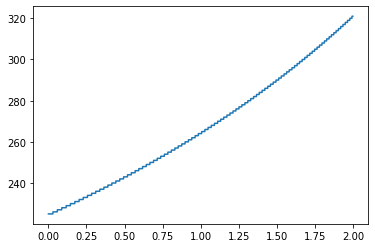

In [542]:
plt.plot(t, Mmax_data)

## sim2_6 Preview System Mod2

In [454]:
# run preview system mod 2

In [22]:
# 予見情報に加工
q = np.array([1, 100, 1, 1, 1, 1])
Q = np.diag(q)

phi = np.vstack(
    [
        np.hstack([np.eye(2), -sysd.C.dot(sysd.A)]),
        np.hstack([np.zeros([4, 2]), sysd.A])
    ]
)
G = np.vstack(
    [
        -sysd.C.dot(sysd.B),
        sysd.B
    ]
)
Gd = np.vstack(
    [
        -sysd.C.dot(sysd.E),
        sysd.E
    ]
)
syser = mycontrol.ss(phi, G, Gd, np.eye(6), Ts)

P, K, E = mycontrol.lqrd(phi, G, Q, H)
K = -K
Fe, Fx = np.hsplit(K, [2])

step = 43 # 予見ステップ数
Fd = np.zeros((step, 2, 4))
for i in range(step):
    Fd[i] = -LA.inv(H+G.T.dot(P).dot(G)).dot(G.T).dot(np.linalg.matrix_power((phi+G.dot(K)).T, i+1)).dot(P).dot(Gd)

x = np.zeros((t.size, 4, 1))
y = np.zeros((t.size, 2, 1))
u = np.zeros((t.size, 2, 1))
d = np.zeros((t.size, 4, 1))
dis = np.zeros((t.size))
v = vs
e = np.zeros((t.size, 2, 1))
yoken = np.zeros((t.size+100, 4, 1))
Mmax = int(l/(v*Ts))

for i in range(t.size-1):
    x[i+1], y[i+1] = sysd.update(x[i], u[i], d[i])
    dis[i+1] = dis[i] + v*Ts
    d[i+1][0], d[i+1][2] = dist(dis[i+1], l)
    d[i+1][1][0] = (d[i+1][0]-d[i][0])/Ts
    d[i+1][3][0] = (d[i+1][2]-d[i][2])/Ts  
    
    # 予見情報
    if i<t.size-Mmax-1:
        yoken[i+1+Mmax][2] = d[i+1][0]*1.5
        yoken[i+1+Mmax][3] = d[i+1][1]*1.5
    
    e[i+1] = -y[i+1]
    dx = x[i+1] - x[i]
    du = Fe.dot(e[i+1]) + Fx.dot(dx)
    
    for j in range(step):
        k = i + j+1

        dw = yoken[k+1]-yoken[k]
        du += Fd[j].dot(dw)
    
    u[i+1] = u[i] + du
    
    v += ac*Ts
    Mmax = int(l/(v*Ts))
    
    
x26, y26, u26, d26, dis26 = x, y, u, d, dis
yoken26 = yoken

## sim2_7 Preview System Mod3

In [57]:
# run preview system mod3

In [480]:
# Hを大きくする
# ただしパワーの上限を設ける
q = np.array([1, 100, 1, 1, 1, 1])
Q = np.diag(q)
h = np.array([1, 1])*10**-8
H = np.diag(h)

phi = np.vstack(
    [
        np.hstack([np.eye(2), -sysd.C.dot(sysd.A)]),
        np.hstack([np.zeros([4, 2]), sysd.A])
    ]
)
G = np.vstack(
    [
        -sysd.C.dot(sysd.B),
        sysd.B
    ]
)
Gd = np.vstack(
    [
        -sysd.C.dot(sysd.E),
        sysd.E
    ]
)
syser = mycontrol.ss(phi, G, Gd, np.eye(6), Ts)

P, K, E = mycontrol.lqrd(phi, G, Q, H)
K = -K
Fe, Fx = np.hsplit(K, [2])

step = 43 # 予見ステップ数
Fd = np.zeros((step, 2, 4))
for i in range(step):
    Fd[i] = -LA.inv(H+G.T.dot(P).dot(G)).dot(G.T).dot(np.linalg.matrix_power((phi+G.dot(K)).T, i+1)).dot(P).dot(Gd)

x = np.zeros((t.size, 4, 1))
y = np.zeros((t.size, 2, 1))
u = np.zeros((t.size, 2, 1))
d = np.zeros((t.size, 4, 1))
dis = np.zeros((t.size))
v = vs
e = np.zeros((t.size, 2, 1))
yoken = np.zeros((t.size+100, 4, 1))
Mmax = int(l/(v*Ts))

for i in range(t.size-1):
    x[i+1], y[i+1] = sysd.update(x[i], u[i], d[i])
    dis[i+1] = dis[i] + v*Ts
    d[i+1][0], d[i+1][2] = dist(dis[i+1], l)
    d[i+1][1][0] = (d[i+1][0]-d[i][0])/Ts
    d[i+1][3][0] = (d[i+1][2]-d[i][2])/Ts  
    
    # 予見情報
    if i<t.size-Mmax-1:
        yoken[i+1+Mmax][2] = d[i+1][0]
        yoken[i+1+Mmax][3] = d[i+1][1]
    
    e[i+1] = -y[i+1]
    dx = x[i+1] - x[i]
    du = Fe.dot(e[i+1]) + Fx.dot(dx)
    
    for j in range(step):
        k = i + j+1

        dw = yoken[k+1]-yoken[k]
        du += Fd[j].dot(dw)
    
    u[i+1] = u[i] + du
    for j in range(len(u[i+1])):
        if u[i+1][j]>1500:
            u[i+1][j] = 1500
        elif u[i+1][j]<-1500:
            u[i+1][j] = -1500
    
    v += ac*Ts
    Mmax = Mmax = int(l/(v*Ts))
    
    
x27, y27, u27, d27, dis27 = x, y, u, d, dis
yoken27 = yoken

h = np.array([1, 1])*10**-5
H = np.diag(h)

## sim2_8 Preview System Mod4

In [28]:
# 速度に合わせて予見の重みを増やす
q = np.array([1, 100, 1, 1, 1, 1])
Q = np.diag(q)

phi = np.vstack(
    [
        np.hstack([np.eye(2), -sysd.C.dot(sysd.A)]),
        np.hstack([np.zeros([4, 2]), sysd.A])
    ]
)
G = np.vstack(
    [
        -sysd.C.dot(sysd.B),
        sysd.B
    ]
)
Gd = np.vstack(
    [
        -sysd.C.dot(sysd.E),
        sysd.E
    ]
)
syser = mycontrol.ss(phi, G, Gd, np.eye(6), Ts)

P, K, E = mycontrol.lqrd(phi, G, Q, H)
K = -K
Fe, Fx = np.hsplit(K, [2])

step = 43 # 予見ステップ数
Fd = np.zeros((step, 2, 4))
for i in range(step):
    Fd[i] = -LA.inv(H+G.T.dot(P).dot(G)).dot(G.T).dot(np.linalg.matrix_power((phi+G.dot(K)).T, i+1)).dot(P).dot(Gd)

x = np.zeros((t.size, 4, 1))
y = np.zeros((t.size, 2, 1))
u = np.zeros((t.size, 2, 1))
d = np.zeros((t.size, 4, 1))
dis = np.zeros((t.size))
v = vs
e = np.zeros((t.size, 2, 1))
yoken = np.zeros((t.size+100, 4, 1))
Mmax = int(l/(v*Ts))

for i in range(t.size-1):
    x[i+1], y[i+1] = sysd.update(x[i], u[i], d[i])
    dis[i+1] = dis[i] + v*Ts
    d[i+1][0], d[i+1][2] = dist(dis[i+1], l)
    d[i+1][1][0] = (d[i+1][0]-d[i][0])/Ts
    d[i+1][3][0] = (d[i+1][2]-d[i][2])/Ts  
    
    # 予見情報
    if i<t.size-Mmax-1:
        yoken[i+1+Mmax][2] = d[i+1][0]*(1+v*0.02)
        yoken[i+1+Mmax][3] = d[i+1][1]*(1+v*0.02)
    
    e[i+1] = -y[i+1]
    dx = x[i+1] - x[i]
    du = Fe.dot(e[i+1]) + Fx.dot(dx)
    
    for j in range(step):
        k = i + j+1
        dw = yoken[k+1]-yoken[k]
        du += Fd[j].dot(dw)
    
    u[i+1] = u[i] + du
    
    v += ac*Ts
    Mmax = Mmax = int(l/(v*Ts))
    
    
x28, y28, u28, d28, dis28 = x, y, u, d, dis
yoken28 = yoken

## sim2_9 Preview System Mod5

In [31]:
# l = vs*t + 1/2 *a*t^2 について解いた結果
q = np.array([1, 100, 1, 1, 1, 1])
Q = np.diag(q)

phi = np.vstack(
    [
        np.hstack([np.eye(2), -sysd.C.dot(sysd.A)]),
        np.hstack([np.zeros([4, 2]), sysd.A])
    ]
)
G = np.vstack(
    [
        -sysd.C.dot(sysd.B),
        sysd.B
    ]
)
Gd = np.vstack(
    [
        -sysd.C.dot(sysd.E),
        sysd.E
    ]
)
syser = mycontrol.ss(phi, G, Gd, np.eye(6), Ts)

P, K, E = mycontrol.lqrd(phi, G, Q, H)
K = -K
Fe, Fx = np.hsplit(K, [2])

step = 43 # 予見ステップ数
Fd = np.zeros((step, 2, 4))
for i in range(step):
    Fd[i] = -LA.inv(H+G.T.dot(P).dot(G)).dot(G.T).dot(np.linalg.matrix_power((phi+G.dot(K)).T, i+1)).dot(P).dot(Gd)

x = np.zeros((t.size, 4, 1))
y = np.zeros((t.size, 2, 1))
u = np.zeros((t.size, 2, 1))
d = np.zeros((t.size, 4, 1))
dis = np.zeros((t.size))
v = vs
e = np.zeros((t.size, 2, 1))
yoken = np.zeros((t.size+100, 4, 1))
# Mmax = int(l/(v*Ts))
s = int((-v+np.sqrt(v*v+2*ac*l))/(ac*Ts))

for i in range(t.size-1):
    x[i+1], y[i+1] = sysd.update(x[i], u[i], d[i])
    dis[i+1] = dis[i] + v*Ts
    d[i+1][0], d[i+1][2] = dist(dis[i+1], l)
    d[i+1][1][0] = (d[i+1][0]-d[i][0])/Ts
    d[i+1][3][0] = (d[i+1][2]-d[i][2])/Ts  
    
    # 予見情報
    e[i+1] = -y[i+1]
    dx = x[i+1] - x[i]
    du = Fe.dot(e[i+1]) + Fx.dot(dx)
    
    for j in range(step):
        k = i+j-s
        if k>-1 and k<1999:
            yoken[1][2:] = d[k+1][:2]
            yoken[0][2:] = d[k][:2]
            dw = yoken[1]-yoken[0]
            du += Fd[j].dot(dw)
    
#     for j in range(step):
#         k = i + j+1
#         dw = yoken[k+1]-yoken[k]
#         du += Fd[j].dot(dw)
    
    u[i+1] = u[i] + du
    
    v += ac*Ts
#     Mmax = Mmax = int(l/(v*Ts))
    
    
x28, y28, u28, d28, dis28 = x, y, u, d, dis
yoken28 = yoken
print(s)

221


## plot

In [51]:
# run sim2 plot

### 状態変数x

In [475]:
# run plot x

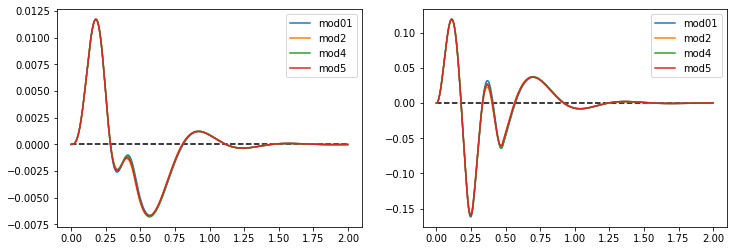

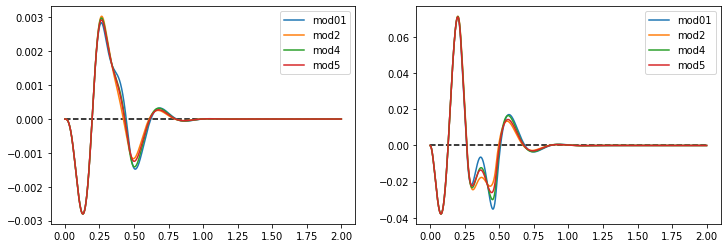

In [33]:
# yn = (x21, x22, x23, x24, x25,)
# gn = ("passive", "feedback", "non preview", "preview", "preview2")
# yn = (x23, x24, x25,x26)
# gn = ("non","mod0", "mod1", "mod2", "mod3")
yn = (x53, x24, x25, x28)
gn = ('mod01', 'mod2', 'mod4', 'mod5')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for i in range(len(yn)):
    plt.plot(t, yn[i][:, 0], label=gn[i])
plt.legend()
plt.hlines([0], 0, end_time, linestyles='dashed')

plt.subplot(1, 2, 2)
for i in range(len(yn)):
    plt.plot(t, yn[i][:, 1], label=gn[i])
plt.legend()
plt.hlines([0], 0, end_time, linestyles='dashed')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for i in range(len(yn)):
    plt.plot(t, yn[i][:, 2], label=gn[i])
plt.legend()
plt.hlines([0], 0, end_time, linestyles='dashed')

plt.subplot(1, 2, 2)
for i in range(len(yn)):
    plt.plot(t, yn[i][:, 3], label=gn[i])
plt.legend()
plt.hlines([0], 0, end_time, linestyles='dashed')

### 入力u

In [163]:
# run plot u

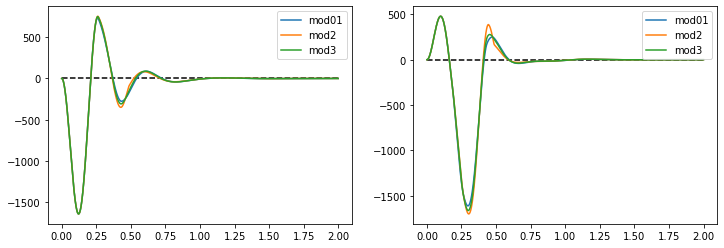

In [48]:
yn = (u21, u22, u23, u24, u25, u26)
gn = ("passive","feedback", "non preview", "preview", 'preview2', 'mod2')
# yn = (u25, u26, u27, u28)
yn = (u53, u24, u25,)
gn = ('mod01', 'mod2', 'mod3', 'mod4')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for i in range(len(yn)):
    plt.plot(t, yn[i][:, 0], label=gn[i])
plt.legend()
plt.hlines([0], 0, end_time, linestyles='dashed')

plt.subplot(1, 2, 2)
for i in range(len(yn)):
    plt.plot(t, yn[i][:, 1], label=gn[i])
plt.legend()
plt.hlines([0], 0, end_time, linestyles='dashed')

### 外乱d

In [130]:
# run plot d

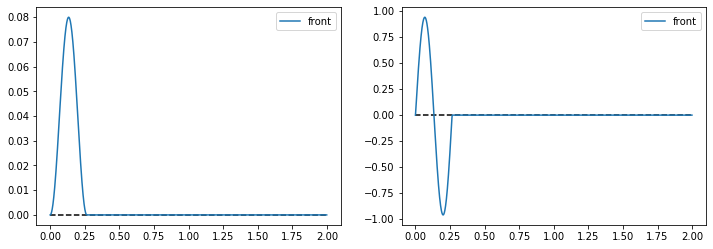

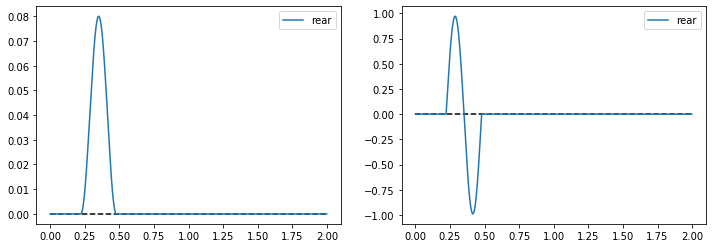

In [49]:
yn = (d21, )

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for y in yn:
    plt.plot(t, y[:, 0], label='front')
plt.hlines([0], 0, end_time, linestyles='dashed')
plt.legend()

plt.subplot(1, 2, 2)
for y in yn:
    plt.plot(t, y[:, 1], label='front')
plt.hlines([0], 0, end_time, linestyles='dashed')
plt.legend()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for y in yn:
    plt.plot(t, y[:, 2], label='rear')
plt.hlines([0], 0, end_time, linestyles='dashed')
plt.legend()

plt.subplot(1, 2, 2)
for y in yn:
    plt.plot(t, y[:, 3], label='rear')
plt.hlines([0], 0, end_time, linestyles='dashed')
plt.legend()

### 距離dis

In [129]:
# run plot dis

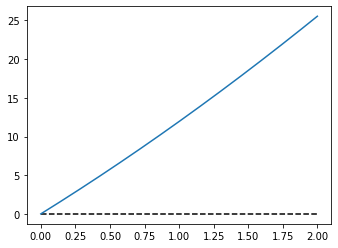

In [50]:
yn = (dis21, )

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for y in yn:
    plt.plot(t, y)
plt.hlines([0], 0, end_time, linestyles='dashed')x

### 予見情報yoken

In [404]:
#run plot yoken

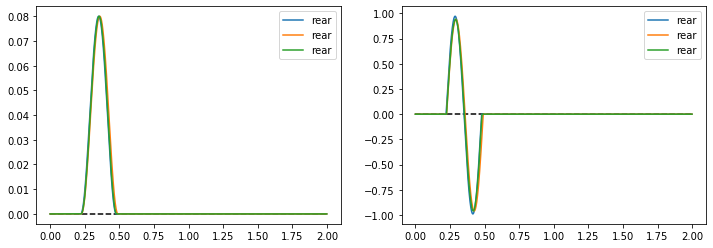

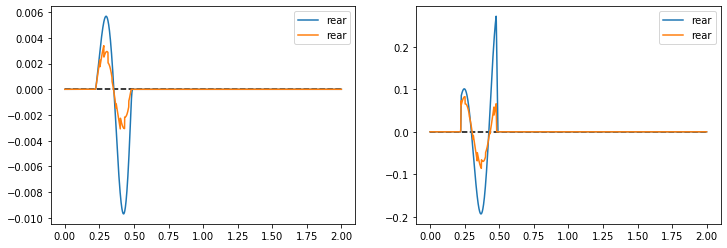

In [53]:
yn = (d24, yoken24[:t.size], yoken25[:t.size],)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for y in yn:
    plt.plot(t, y[:, 2], label='rear')
plt.hlines([0], 0, end_time, linestyles='dashed')
plt.legend()

plt.subplot(1, 2, 2)
for y in yn:
    plt.plot(t, y[:, 3], label='rear')
plt.hlines([0], 0, end_time, linestyles='dashed')
plt.legend()


yn = (d24-yoken24[:t.size], d25-yoken25[:t.size], )

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for y in yn:
    plt.plot(t, y[:, 2], label='rear')
plt.hlines([0], 0, end_time, linestyles='dashed')
plt.legend()

plt.subplot(1, 2, 2)
for y in yn:
    plt.plot(t, y[:, 3], label='rear')
plt.hlines([0], 0, end_time, linestyles='dashed')
plt.legend()

# test

## test1 yoken

In [334]:
# run test1

In [55]:
vs = 30
a = 6
l = 3
Ts = 0.001
k = (-vs + np.sqrt(vs*vs+2*a*l))/(a*Ts)
print(k)

99.01951359278509


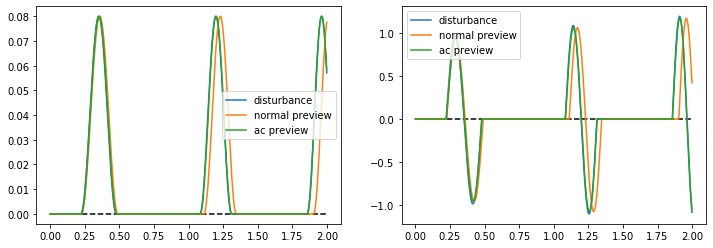

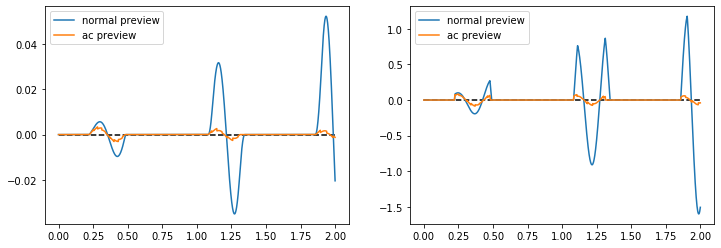

In [76]:
step = 43 # 予見ステップ数

d = np.zeros((t.size, 4, 1))
dis = np.zeros((t.size))
v = vs
yoken1 = np.zeros((t.size+100, 4, 1))
yoken2 = np.zeros((t.size+100, 4, 1))
yoken3 = np.zeros((t.size+100, 4, 1))
Mmax = int(l/(v*Ts))
Mmax2 = int(l/(v*Ts))

for i in range(t.size-1):
    dis[i+1] = dis[i] + v*Ts
    d[i+1][0], d[i+1][2] = dist(dis[i+1], l)
    d[i+1][1][0] = (d[i+1][0]-d[i][0])/Ts
    d[i+1][3][0] = (d[i+1][2]-d[i][2])/Ts
    
    # 予見情報
    ## yoken1
    if i<t.size-Mmax-1:
        yoken1[i+1+Mmax][2] = d[i+1][0]
        yoken1[i+1+Mmax][3] = d[i+1][1]
        
    # yoken2
    # 予見情報終わり
    if i<t.size-Mmax2-1:
        
        yoken2[i+1+Mmax2][2] = d[i+1][0]
        yoken2[i+1+Mmax2][3] = d[i+1][1]
        
    # yoken3
    
    
    v += ac*Ts
    Mmax2 = int(l/(v*Ts))
    
d51, dis51 = d, dis
yoken511 = yoken1
yoken512 = yoken2

# そのまま比較
yn = (d51, yoken511[:t.size], yoken512[:t.size], )
gn = ('disturbance', 'normal preview', 'ac preview', )

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for i in range(len(yn)):
    plt.plot(t, yn[i][:, 2], label=gn[i])
plt.legend()
plt.hlines([0], 0, end_time, linestyles='dashed')

plt.subplot(1, 2, 2)
for i in range(len(yn)):
    plt.plot(t, yn[i][:, 3], label=gn[i])
plt.legend()
plt.hlines([0], 0, end_time, linestyles='dashed')

# 差分比較
yn = (d51-yoken511[:t.size], d51-yoken512[:t.size], )
# yn = (d51-yoken511[:t.size], )
gn = ('normal preview', 'ac preview', )

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for i in range(len(yn)):
    plt.plot(t, yn[i][:, 2], label=gn[i])
plt.legend()
plt.hlines([0], 0, end_time, linestyles='dashed')

plt.subplot(1, 2, 2)
for i in range(len(yn)):
    plt.plot(t, yn[i][:, 3], label=gn[i])
plt.legend()
plt.hlines([0], 0, end_time, linestyles='dashed')

## test2 外乱予測修正

In [415]:
# run test2

In [416]:
sysd = mycontrol.ss(Ap, Bp, Ep, Cp, Ts)

start_time = 0
end_time = 2
t = np.arange(start_time, end_time, Ts)

# 0-100km/h : 12秒程度
# 最大の加速度=>加速度 : 8.5km/h程度
# 加速度 6km/h と仮定
start_v = 40
end_v = 50
ac_v = 6
vs = start_v*1000/3600
ac = ac_v*1000/3600
print(ac_v)

6


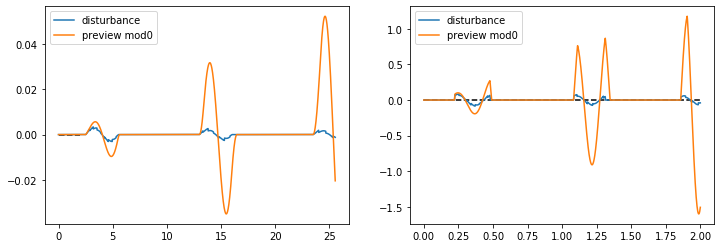

In [417]:
step = 43 # 予見ステップ数

d = np.zeros((t.size, 4, 1))
dis = np.zeros((t.size))
v = vs
yoken1 = np.zeros((t.size+100, 4, 1))
yoken2 = np.zeros((t.size+100, 4, 1))
yoken3 = np.zeros((t.size+100, 4, 1))
Mmax = int(l/(v*Ts))
Mmax2 = int(l/(v*Ts))

for i in range(t.size-1):
    dis[i+1] = dis[i] + v*Ts
    d[i+1][0], d[i+1][2] = dist(dis[i+1], l)
    d[i+1][1][0] = (d[i+1][0]-d[i][0])/Ts
    d[i+1][3][0] = (d[i+1][2]-d[i][2])/Ts
    
    # 予見情報
    ## yoken1
    if i<t.size-Mmax-1:
        yoken1[i+1+Mmax][2] = d[i+1][0]
        yoken1[i+1+Mmax][3] = d[i+1][1]
        
    # yoken2
    if i<t.size-Mmax2-1:
        yoken2[i+1+Mmax2][2] = d[i+1][0]
        yoken2[i+1+Mmax2][3] = d[i+1][1]
        
    # yoken3
    if i<t.size-Mmax2-1:
        yoken3[i+1+Mmax2][2] = d[i+1][0]
        yoken3[i+1+Mmax2][3] = (yoken3[i+1+Mmax2][2]-yoken3[i+Mmax2][2])/Ts
    
    # 予見情報終わり
    
    v += ac*Ts
    Mmax2 = int(l/(v*Ts))
    
d52, dis52 = d, dis

# そのまま比較
xn = (dis52, dis52, dis52, dis52, )
yn = (d52, yoken1[:t.size], yoken2[:t.size], yoken3[:t.size], )
gn = ('disturbance', 'preview mod0', 'preview mod1', 'preview mode2', )
xn = (dis52, dis52, dis52, dis52, )
yn = (d52, yoken2[:t.size], yoken3[:t.size], )
yn = (d52-yoken2[:t.size], d52-yoken1[:t.size])

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for i in range(len(yn)):
    plt.plot(xn[i], yn[i][:, 2], label=gn[i])
plt.legend()
plt.hlines([0], 0, end_time, linestyles='dashed')

plt.subplot(1, 2, 2)
for i in range(len(yn)):
    plt.plot(t, yn[i][:, 3], label=gn[i])
plt.legend()
plt.hlines([0], 0, end_time, linestyles='dashed')

## test3 予見が正しいとき

In [556]:
# run test3

In [25]:
q = np.array([1, 100, 1, 1, 1, 1])
Q = np.diag(q)

phi = np.vstack(
    [
        np.hstack([np.eye(2), -sysd.C.dot(sysd.A)]),
        np.hstack([np.zeros([4, 2]), sysd.A])
    ]
)
G = np.vstack(
    [
        -sysd.C.dot(sysd.B),
        sysd.B
    ]
)
Gd = np.vstack(
    [
        -sysd.C.dot(sysd.E),
        sysd.E
    ]
)
syser = mycontrol.ss(phi, G, Gd, np.eye(6), Ts)

P, K, E = mycontrol.lqrd(phi, G, Q, H)
K = -K
Fe, Fx = np.hsplit(K, [2])

step = 43 # 予見ステップ数
Fd = np.zeros((step, 2, 4))
for i in range(step):
    Fd[i] = -LA.inv(H+G.T.dot(P).dot(G)).dot(G.T).dot(np.linalg.matrix_power((phi+G.dot(K)).T, i+1)).dot(P).dot(Gd)

x = np.zeros((t.size, 4, 1))
y = np.zeros((t.size, 2, 1))
u = np.zeros((t.size, 2, 1))
d = np.zeros((t.size, 4, 1))
dis = np.zeros((t.size))
v = vs
e = np.zeros((t.size, 2, 1))
yoken = np.zeros((t.size+100, 4, 1))
Mmax = int(l/(v*Ts))

# 予見情報

d = np.zeros((t.size, 4, 1))
dis = np.zeros((t.size))
v = vs

for i in range(t.size-1):
    dis[i+1] = dis[i] + v*Ts
    d[i+1][0], d[i+1][2] = dist(dis[i+1], l)
    d[i+1][1][0] = (d[i+1][0]-d[i][0])/Ts
    d[i+1][3][0] = (d[i+1][2]-d[i][2])/Ts
    
    v += ac*Ts
    
yoken[:t.size, 2] = d[:, 2]*(1+v*0.02)
yoken[:t.size, 3] = d[:, 3]*(1+v*0.02)

# 予見情報終わり

d = np.zeros((t.size, 4, 1))
dis = np.zeros((t.size))
v = vs

for i in range(t.size-1):
    x[i+1], y[i+1] = sysd.update(x[i], u[i], d[i])
    dis[i+1] = dis[i] + v*Ts
    d[i+1][0], d[i+1][2] = dist(dis[i+1], l)
    d[i+1][1][0] = (d[i+1][0]-d[i][0])/Ts
    d[i+1][3][0] = (d[i+1][2]-d[i][2])/Ts  
    
    e[i+1] = -y[i+1]
    dx = x[i+1] - x[i]
    du = Fe.dot(e[i+1]) + Fx.dot(dx)
    
    for j in range(step):
        k = i + j+1
        dw = yoken[k+1]-yoken[k]
        du += Fd[j].dot(dw)
    b
    u[i+1] = u[i] + du
    
    v += ac*Ts
    
    
x531, y531, u531, d531, dis531 = x, y, u, d, dis
# yoken53 = yoken

# xn = (dis52, dis52, dis52, dis52, )
# yn = (d53-yoken25[:t.size], d53-yoken53[:t.size], )
# gn = ('disturbance', 'preview mod0', 'preview mod1', 'preview mode2', )

# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# for i in range(len(yn)):
#     plt.plot(xn[i], yn[i][:, 2], label=gn[i])
# plt.legend()
# plt.hlines([0], 0, end_time, linestyles='dashed')

# plt.subplot(1, 2, 2)
# for i in range(len(yn)):
#     plt.plot(t, yn[i][:, 3], label=gn[i])
# plt.legend()
# plt.hlines([0], 0, end_time, linestyles='dashed')

In [26]:
q = np.array([1, 100, 1, 1, 1, 1])
Q = np.diag(q)

phi = np.vstack(
    [
        np.hstack([np.eye(2), -sysd.C.dot(sysd.A)]),
        np.hstack([np.zeros([4, 2]), sysd.A])
    ]
)
G = np.vstack(
    [
        -sysd.C.dot(sysd.B),
        sysd.B
    ]
)
Gd = np.vstack(
    [
        -sysd.C.dot(sysd.E),
        sysd.E
    ]
)
syser = mycontrol.ss(phi, G, Gd, np.eye(6), Ts)

P, K, E = mycontrol.lqrd(phi, G, Q, H)
K = -K
Fe, Fx = np.hsplit(K, [2])

step = 43 # 予見ステップ数
Fd = np.zeros((step, 2, 4))
for i in range(step):
    Fd[i] = -LA.inv(H+G.T.dot(P).dot(G)).dot(G.T).dot(np.linalg.matrix_power((phi+G.dot(K)).T, i+1)).dot(P).dot(Gd)

x = np.zeros((t.size, 4, 1))
y = np.zeros((t.size, 2, 1))
u = np.zeros((t.size, 2, 1))
d = np.zeros((t.size, 4, 1))
dis = np.zeros((t.size))
v = vs
e = np.zeros((t.size, 2, 1))
yoken = np.zeros((t.size+100, 4, 1))
Mmax = int(l/(v*Ts))

# 予見情報

d = np.zeros((t.size, 4, 1))
dis = np.zeros((t.size))
v = vs

for i in range(t.size-1):
    dis[i+1] = dis[i] + v*Ts
    d[i+1][0], d[i+1][2] = dist(dis[i+1], l)
    d[i+1][1][0] = (d[i+1][0]-d[i][0])/Ts
    d[i+1][3][0] = (d[i+1][2]-d[i][2])/Ts
    
    v += ac*Ts
    
yoken[:t.size, 2] = d[:, 2]
yoken[:t.size, 3] = d[:, 3]

# 予見情報終わり

d = np.zeros((t.size, 4, 1))
dis = np.zeros((t.size))
v = vs

for i in range(t.size-1):
    x[i+1], y[i+1] = sysd.update(x[i], u[i], d[i])
    dis[i+1] = dis[i] + v*Ts
    d[i+1][0], d[i+1][2] = dist(dis[i+1], l)
    d[i+1][1][0] = (d[i+1][0]-d[i][0])/Ts
    d[i+1][3][0] = (d[i+1][2]-d[i][2])/Ts  
    
    e[i+1] = -y[i+1]
    dx = x[i+1] - x[i]
    du = Fe.dot(e[i+1]) + Fx.dot(dx)
    
    for j in range(step):
        k = i + j+1
        dw = yoken[k+1]-yoken[k]
        du += Fd[j].dot(dw)
    b
    u[i+1] = u[i] + du
    
    v += ac*Ts
    
    
x53, y53, u53, d53, dis53 = x, y, u, d, dis

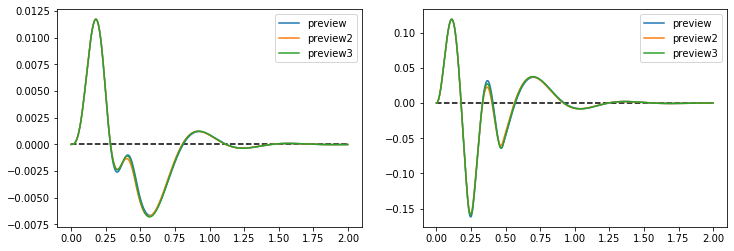

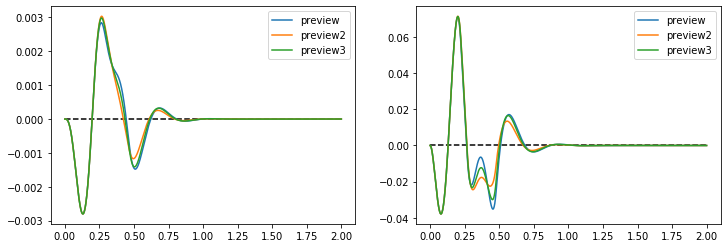

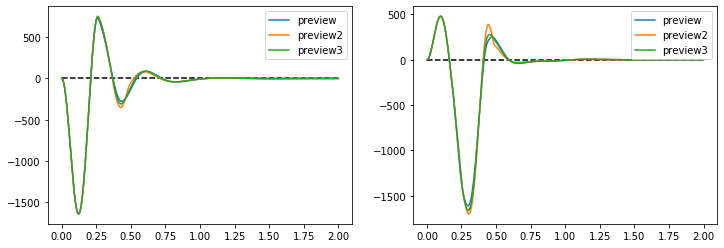

In [27]:
yn = (x53, x24, x25)
gn = ("preview", "preview2", "preview3", "preview4", "preview5")
# yn = (u24, u25,  u53, )
# yn = (u25-u24, u53-u24)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for i in range(len(yn)):
    plt.plot(t, yn[i][:, 0], label=gn[i])
plt.legend()
plt.hlines([0], 0, end_time, linestyles='dashed')

plt.subplot(1, 2, 2)
for i in range(len(yn)):
    plt.plot(t, yn[i][:, 1], label=gn[i])
plt.legend()
plt.hlines([0], 0, end_time, linestyles='dashed')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for i in range(len(yn)):
    plt.plot(t, yn[i][:, 2], label=gn[i])
plt.legend()
plt.hlines([0], 0, end_time, linestyles='dashed')

plt.subplot(1, 2, 2)
for i in range(len(yn)):
    plt.plot(t, yn[i][:, 3], label=gn[i])
plt.legend()
plt.hlines([0], 0, end_time, linestyles='dashed')

yn = (u53, u24, u25, )

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for i in range(len(yn)):
    plt.plot(t, yn[i][:, 0], label=gn[i])
plt.legend()
plt.hlines([0], 0, end_time, linestyles='dashed')

plt.subplot(1, 2, 2)
for i in range(len(yn)):
    plt.plot(t, yn[i][:, 1], label=gn[i])
plt.legend()
plt.hlines([0], 0, end_time, linestyles='dashed')

## test4 平均誤差率

In [42]:
mes = '入力-後輪'
en = (u53[:,1], u24[:,1], u25[:, 1], u23[:, 1], u28[:, 1])
gn = ('理論値', 'preview', 'preview mod1', 'non preview', 'mod5', 'mod3', 'mod4')
# en = (u53[:, 1], u25[:, 1], u26[:, 1], u28[:, 1], u531[:,1])
# gn = ('theo', 'mod1', 'mod2', 'mod4', 'mod4t')
rmse(en, gn, mes)

入力-後輪
理論値 403.08686891102866
preview 416.3505316531845
preview mod1 409.1817264449793
non preview 441.6285991095318
mod5 410.995846361096


In [46]:
mes = '車体変位'
en = (x53[:, 0]*100, x24[:, 0]*100, x25[:, 0]*100, x23[:, 0]*100, x28[:,0]*100)
gn = ('理論値', 'preview', 'preview mod1', 'non preview', 'mod5', 'mod3', 'mod4')
# en = (x53[:, 0]*100, x25[:, 0]*100, x26[:, 0]*100, x28[:, 0]*100, x531[:, 0]*100)
# gn = ('theo', 'mod1', 'mod2', 'mod4', 'mod4t')
rmse(en, gn, mes)

車体変位
理論値 0.33668369851642915
preview 0.3383905147661719
preview mod1 0.3388558832765053
non preview 0.4105268234957822
mod5 0.33714904365357246


In [47]:
mes = '角度変位'
en = (x53[:, 2]*100, x24[:, 2]*100, x25[:, 2]*100, x23[:, 2]*100, x28[:,2]*100)
gn = ('理論値', 'preview', 'preview mod1', 'non preview', 'mod5', 'mod3', 'mod4')
# en = (x53[:, 2]*100, x25[:, 2]*100, x26[:, 2]*100, x28[:, 2]*100)
# gn = ('theo', 'mod1', 'mod2', 'mod4')
rmse(en, gn, mes)

角度変位
理論値 0.08906322418879573
preview 0.08806545648871217
preview mod1 0.0895608384015418
non preview 0.16598415988040252
mod5 0.0876647468810433


In [48]:
mes = '角速度'
en = (x53[:, 3]*100, x24[:, 3]*100, x25[:, 3]*100, x23[:, 3]*100, x28[:,3]*100)
gn = ('理論値', 'preview', 'preview mod1', 'non preview', 'mod2', 'mod3', 'mod4')
# en = (x53[:, 3]*100, x25[:, 3]*100, x26[:, 3]*100, x28[:, 3]*100)
# gn = ('theo', 'mod1', 'mod2', 'mod4')
rmse(en, gn, mes)

角速度
理論値 1.5978545409274048
preview 1.582493680619774
preview mod1 1.6028096410057362
non preview 2.7815779049709026
mod2 1.5697942678377477


In [45]:
def rmse(en, gn, mes=None):
    if mes!=None:
        print(mes)
    for i in range(len(en)):
        e, g = en[i], gn[i]
        n = e.shape[0]
        print(g, np.sqrt(np.sum(e*e)/n))

# グラフ作成

NameError: name 'd11' is not defined

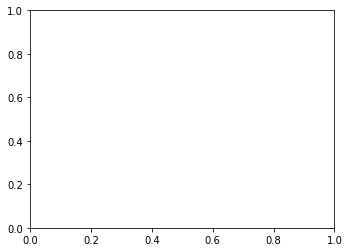

In [412]:
d = d21

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(t, d11[:, 0], label='front')
plt.plot(t, d11[:, 2], label='rear')
plt.legend()
plt.hlines([0], 0, end_time, linestyles='dashed')

yn = (x11, x21)
gn = ("passive", "feedback", "non preview", "preview")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for i in range(len(yn)):
    plt.plot(t, yn[i][:, 0], label=gn[i])
plt.legend()
plt.hlines([0], 0, end_time, linestyles='dashed')

plt.subplot(1, 2, 2)
for i in range(len(yn)):
    plt.plot(t, yn[i][:, 1], label=gn[i])
plt.legend()
plt.hlines([0], 0, end_time, linestyles='dashed')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for i in range(len(yn)):
    plt.plot(t, yn[i][:, 0], label=gn[i])
plt.legend()
plt.hlines([0], 0, end_time, linestyles='dashed')

plt.subplot(1, 2, 2)
for i in range(len(yn)):
    plt.plot(t, yn[i][:, 0], label=gn[i])
plt.legend()
plt.hlines([0], 0, end_time, linestyles='dashed')

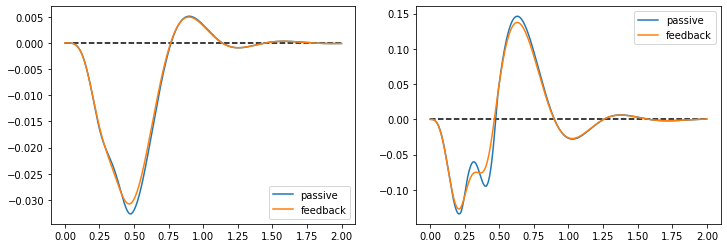

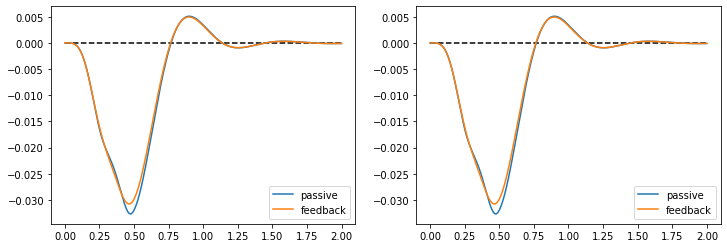

In [167]:
x15 = x13-x12
x25 = x23-x22

yn = (x15, x25)
gn = ("passive", "feedback", "non preview", "preview")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for i in range(len(yn)):
    plt.plot(t, yn[i][:, 0], label=gn[i])
plt.legend()
plt.hlines([0], 0, end_time, linestyles='dashed')

plt.subplot(1, 2, 2)
for i in range(len(yn)):
    plt.plot(t, yn[i][:, 1], label=gn[i])
plt.legend()
plt.hlines([0], 0, end_time, linestyles='dashed')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for i in range(len(yn)):
    plt.plot(t, yn[i][:, 0], label=gn[i])
plt.legend()
plt.hlines([0], 0, end_time, linestyles='dashed')

plt.subplot(1, 2, 2)
for i in range(len(yn)):
    plt.plot(t, yn[i][:, 0], label=gn[i])
plt.legend()
plt.hlines([0], 0, end_time, linestyles='dashed')

# 実行用コマンド

In [14]:
# run all preparation

In [7]:
# run essential

In [13]:
# run init

In [131]:
# run sim1 and plot

In [ ]:
# run sim2 and plot

# 依存関係
## ライブラリー
1. numpy
1. matplotlib
1. scipy
1. python control

## その他
1. jupyter note
1. jupyter note extention
    1. Execution Dependencies

# memo

前提:前輪の状態が使えるものとする
